# OBJVAE

## Init

In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE.single import objVAE_single
from objVAE.single import bg_single
from objVAE.single import utils_single

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

### Helper functions

In [21]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        alpha = z_pres.detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        xy = xy.detach().cpu().numpy()[:]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

## Run/Test

### Load data

torch.Size([3000, 1, 81, 128])


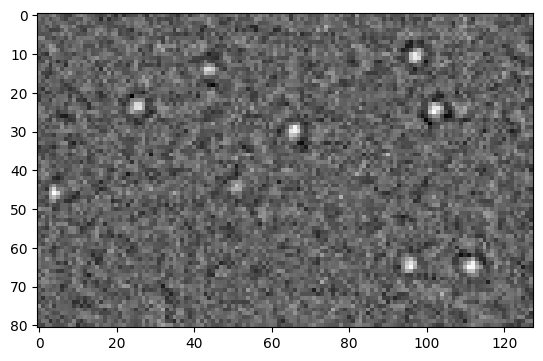

In [14]:
import tifffile

path = r'/data/mp_mpa/simulated/Sim_results_Low.tiff'

images = tifffile.imread(path, key=range(300, 12300, 4))

images = np.abs((images-np.min(images))/(np.max(images)-np.min(images)) - 1)
training_images = torch.tensor(np.array(images), dtype=torch.float32)
training_images = training_images - torch.mean(training_images)
training_images = training_images / torch.std(training_images, dim=(0, 1, 2), keepdim=True) / 3
training_images = torch.unsqueeze(training_images, axis=1)
print(training_images.shape)
plt.imshow(np.squeeze(training_images[8,:,:,:]), cmap='gray')

In [15]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

### Create model

In [16]:
import IPython.display as ipd
import pytorch_lightning as pl

# Callbacks
max_steps = 20000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 2500
unfreeze = 0

def beta_annealing(step):
    logs = np.logspace(-0, -0, beta_annealing_end) # 8.3 - 7
    if step < unfreeze:
        return 0
    if step < beta_annealing_end:
        return 0
    else:
        return 0
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < kl_annealing_end*0.5:
        return 0
    if step < kl_annealing_end:
        return 0
    else:
        return 0

def presence_annealing(step):
    lins = np.linspace(0.1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def unfreeze_foreground(step):
    for param in model.model.parameters():
        param.requires_grad = True



class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)

class UnfreezeCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch == 100:
            unfreeze_foreground(model)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 2:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [22]:
importlib.reload(objVAE_single)
importlib.reload(bg_single)

load_model = ""

#load_model = "../state_dicts/model-musc-bg.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


num_entities = 25
softmax_tmp = 1
latent_dim = 5
beta = 1e-4
number_of_heads = 1
object_radius = 8
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=1
decoder_num_layers=10

single_decoder = True

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

background_model = bg_single.objBG(in_channels=1,image_size=128, **bg_params)
    


model = objVAE_single.MEVAE(
    num_entities,
    background_model=background_model,
    beta=beta,
    latent_dim=latent_dim,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


In [18]:
for param in model.model.parameters():
    param.requires_grad = True

### Train

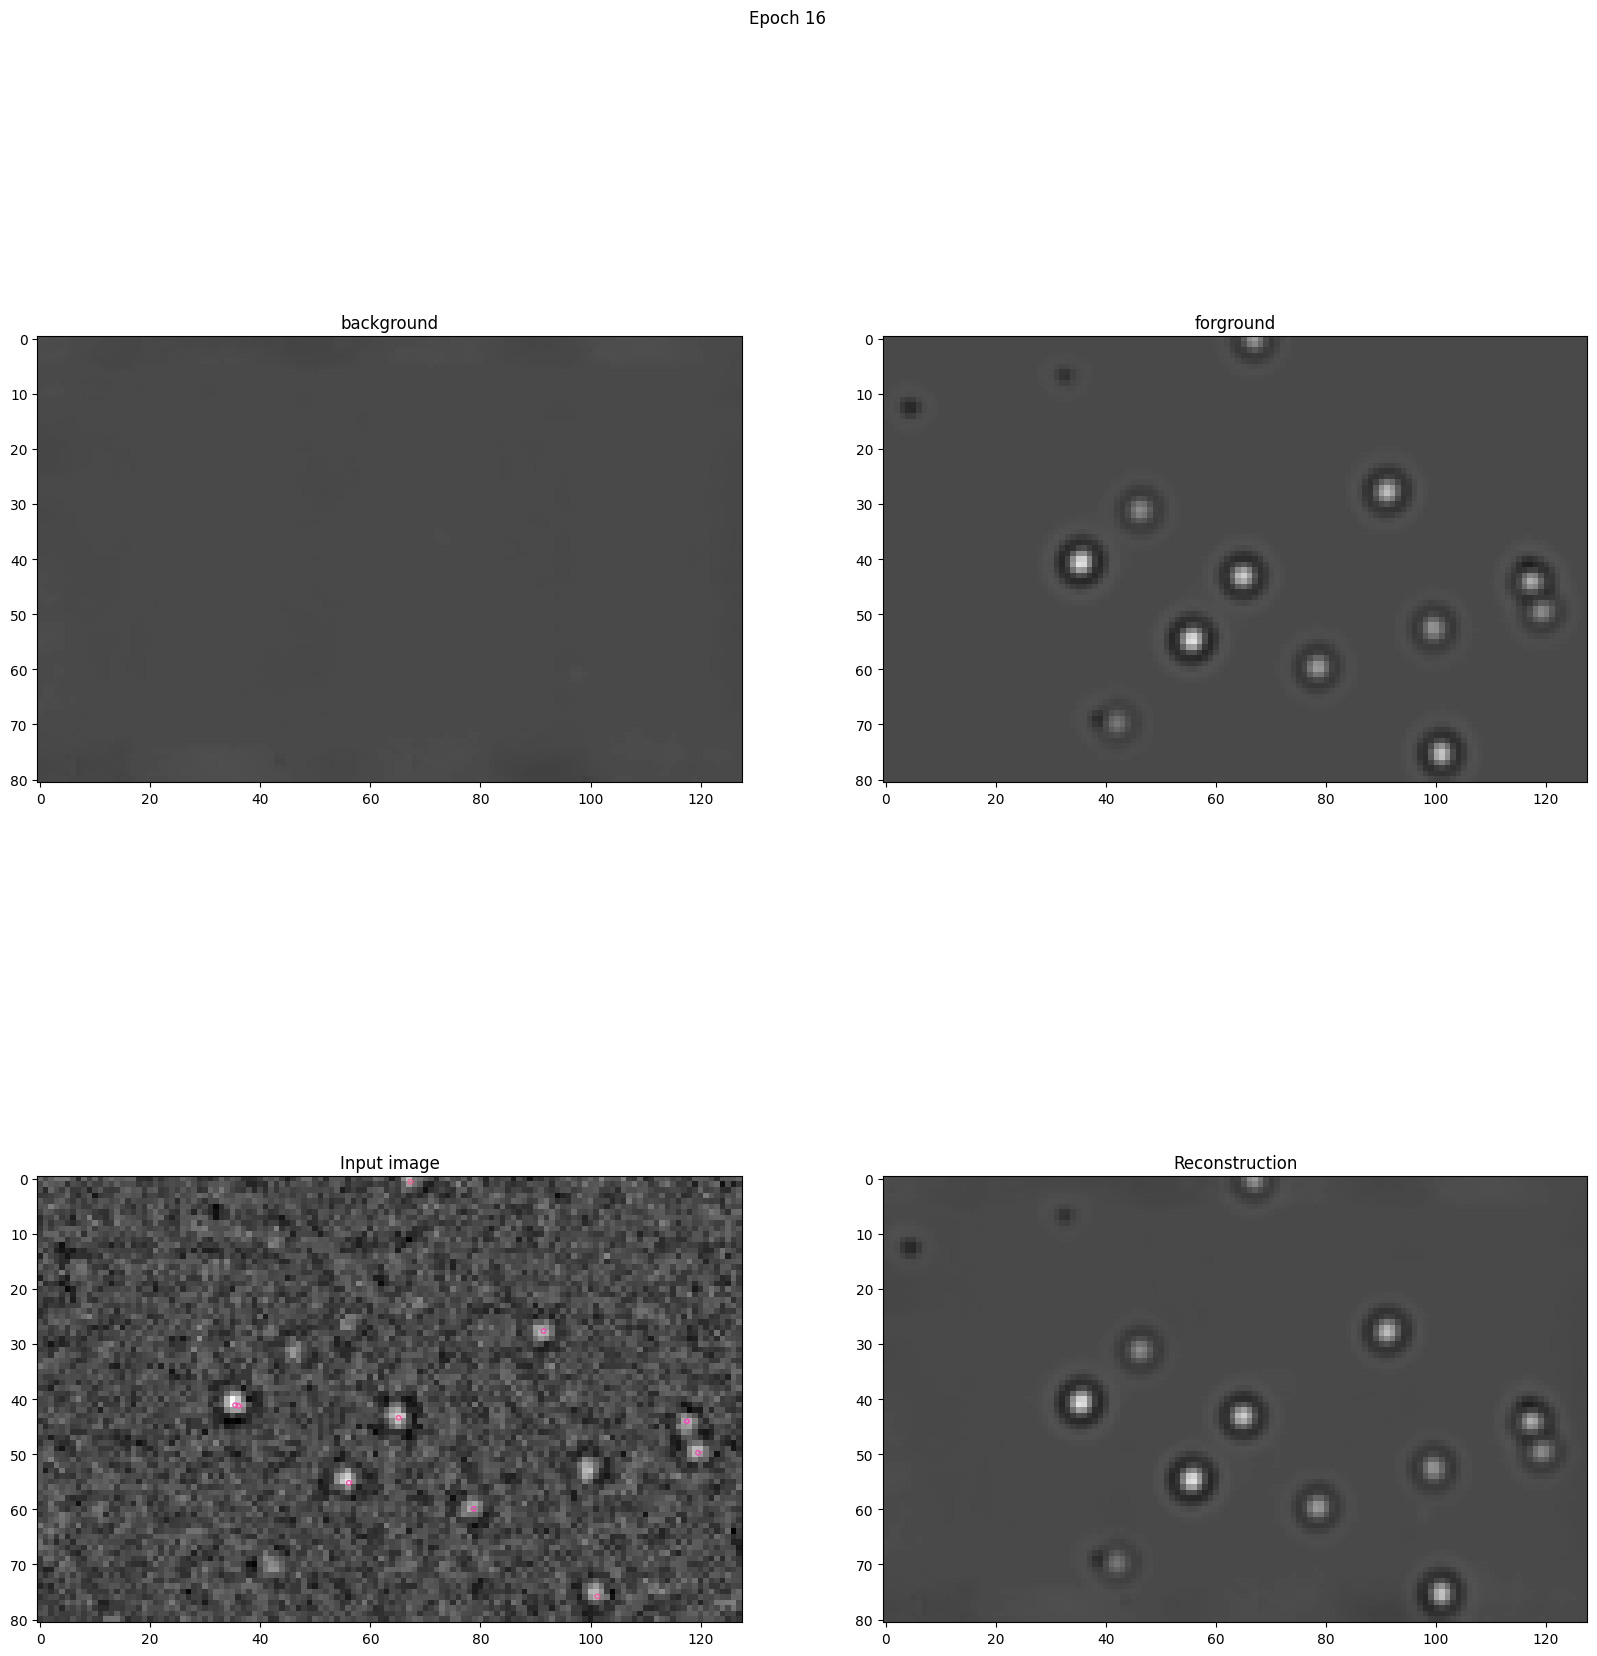

Epoch 16:  67%|██████▋   | 800/1200 [00:19<00:09, 40.53it/s, v_num=2242, loss_step=0.0886, recon_loss_step=0.0886, kl_loss_step=67.50, kl_for_step=29.60, kl_back_step=38.00, loss_epoch=0.0775, recon_loss_epoch=0.0775, kl_loss_epoch=78.30, kl_for_epoch=29.70, kl_back_epoch=48.60]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 16:  67%|██████▋   | 800/1200 [00:19<00:09, 40.45it/s, v_num=2242, loss_step=0.0886, recon_loss_step=0.0886, kl_loss_step=67.50, kl_for_step=29.60, kl_back_step=38.00, loss_epoch=0.0775, recon_loss_epoch=0.0775, kl_loss_epoch=78.30, kl_for_epoch=29.70, kl_back_epoch=48.60]


In [23]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

### Test

In [20]:
print(model.model.kl_importance)
model.model.kl_importance = 0

1


In [66]:
importlib.reload(utils_single)

utils_single.run_test(
    training_images,
    model,
    combine_radius=2,
    plot_num=None,
    num_entities=25,
    pres_floor=0.25,
    )

ERROR! Session/line number was not unique in database. History logging moved to new session 398


/workspace/aa-attention/objVAE/objVAE/single/utils_single.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-MP-firstworking.pth")